This Jupyter Notebook contains the first project for Information Retrieval 1 taught at the UvA. Code is made by Oscar Ligthart, Nicole Ferreira Silverio and Arend van Dormalen.

# Question 1A

The chance of a type 1 error ($\alpha$) increases each time an experiment is repeated, if it's not corrected. The new $\alpha$ for _m_ experiments is $1 − (1 − \alpha)^m ≈ m\alpha$. This is called the Family-wise error rate.

# Question 1B,

The chance of a type 1 error needs to be corrected in order to find the chance of an experiment existing that rejects the null hypothesis. This can be done by the Bonferroni correction, which rejects the null hypothesis for any $p_i$ when it it lower than or equal to $\frac{\alpha}{m}$.
      

# Question 2

Assume two ranked lists created by two different rankers. List $l1$ contains documents $d1$, $d2$ and $d3$ in that order. List $l2$ contains documents $d2$, $d3$ and $d4$ in that order. Now assume that the only relevant document is $d3$, which will therefore be clicked on most often. From our judgment, it is obvious that $l2$ is the most relevant list as it has placed $d3$ on a higher position. However, in Team Draft Interleaving, these algorithms will be evaluated as having equal performance.

In this situation, $d3$ will always be the third item on the interleaved list. After the first coin flip, $d2$ will be removed from $l1$ as this document has already been supplied by $l2$.  At the second coin flip, $d3$ will be the next document for both lists. This causes the relevance for both lists to be the same, as they now both have the same chance of supplying the only relevant document to the interleaved list.

The following cell represents the creation of all possible relevance pairs E and P

In [1]:
import itertools
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import statistics
import scipy.stats

# first get the sequence options
relevance = ['N', 'R', 'HR']
options = list(itertools.product(relevance, repeat = 5))

# create all possible pairs in sequence options
pair_index = list(itertools.permutations(range(len(options)), 2))


pairs = []

for temp_pair in pair_index:
    pairs.append([options[temp_pair[0]], options[temp_pair[1]]])    


# Offline measures

Each cell represents one of the following three offline measures: Average precision, nDCG, ERR

## Average precision

In [2]:
def get_average_precision(ranking):
    rel = 0
    AP_numerator = 0
    # get amount of relevant documents
    for i, doc in enumerate(ranking):
        if doc == 'R' or doc == 'HR':
            rel += 1
            AP_numerator += rel/(i+1)
            
    return rel, AP_numerator

# new dict for average precision for both P and E (key is pair, value is average precisions))
AP_delta = {}

# new dict for delta measures (AP, nDCG and ERR will be stored here per pair)
delta_values = {}

# get precision for all pairs
for pair in pairs:
    # first calculate numerator for average precision for P
    P = pair[0]    
    P_rel, P_AP_numerator = get_average_precision(P)
 
    # now calculate numerator for average precision for E
    E = pair[1]
    E_rel, E_AP_numerator = get_average_precision(E)

    # get total number of relevant documents returned from query
    total_rel = P_rel + E_rel
    
    # calculate average precision for both P and E
    P_AP = P_AP_numerator/total_rel
    E_AP = E_AP_numerator/total_rel
    
    # store results in a dict
    AP_delta[(P,E)] = [E_AP - P_AP]
    
    # store AP delta measures in list format in dict
    delta_values[(P,E)] = [E_AP - P_AP]


## nDCG

In [3]:
##### nDCG cell #####
def get_nDCG(ranking):
    DCG = 0
    
    # loop through ranking
    for i, rank in enumerate(ranking):
        # decide what the relative rank is
        if rank == 'HR':
            rel_r = 2
        elif rank == 'R':
            rel_r = 1
        elif rank == 'N':
            rel_r = 0
        
        DCG += (2**rel_r - 1)/(np.log2(1+(i+1)))
    
    return DCG

# new dict for average precision for both P and E (key is pair, value is average precisions))
nDCG_delta = {}

counter = 0
same_counter = 0
lower_counter = 0

# get nDCG for all pairs
for pair in pairs:    
    # first for P
    P = pair[0]
    P_DCG = get_nDCG(P)
    
    # then for E
    E = pair[1]
    E_DCG = get_nDCG(E)
    
    nDCG_delta[(P,E)] = [E_DCG - P_DCG]
    
    # add nDCG delta measure to dict
    delta_values[(P,E)].append(E_DCG - P_DCG)



## ERR 

In [4]:

def get_ERR(ranking):
    
    ERR = 0
    p = 1
    max_rel = 2
    
    # loop through ranking
    for i, rank in enumerate(ranking):        
        # start at second rank
        if i != 0:            
            # decide what the relative rank is
            if rank == 'HR':
                rel_r = 2
            elif rank == 'R':
                rel_r = 1
            elif rank == 'N':
                rel_r = 0

            # Calculate R with the mapping function
            R = (2**rel_r - 1)/(2**max_rel)

            # Modify ERR value
            ERR += p * (R/i)

            # Modify p
            p = p*(1-R)
    
    return ERR

# new dict for ERR values for both P and E (key is pair, value is ERR value))
ERR_delta = {}

# get ERR for all pairs
for pair in pairs:
    
    # first for P
    P = pair[0]
    P_ERR = get_ERR(P)
    
    # then for E
    E = pair[1]
    E_ERR = get_ERR(E)
    
    ERR_delta[(P,E)] = [E_ERR - P_ERR]
    
    # add ERR delta measures to dict
    delta_values[(P,E)].append(E_ERR -  P_ERR)
    


# Filtering and interleaving pairs
In the following cells the pairs that hold delta values that are positive are extracted for further use. We extracted the pairs holding a positive delta value for all offline measures. Moreover, we took the mean of delta values from all offline measures and extracted the pairs that had a positive delta value for this mean.
Afterwards, we used balance interleaving to create one ranking out of both algorithms for every pair where E outperforms P.

In [5]:
##### Filter pairs #####

def filter_pairs(pairs_dict):
    # this function is used to extract pairs that have a positive delta value for the mean of all offline measures
    pairs_list = []
    dict_items = pairs_dict.items()
    for pair in dict_items:
        scores = pair[1]
        avg = sum(scores, 0.0)/len(scores)
        if avg > 0.0:
            pairs_list.append(pair[0])
    
    return pairs_list

def interleaving(pairs):
    # this function 
    all_results = []
    all_origins = []
    for pair in pairs:

        # Flip a coin, assign winning and losing
        # P = pair[0], E = pair[1]
        coin_winner = random.randint(0,1)
        winner = pair[coin_winner]
        loser = pair[1 - coin_winner]

        # initiate lists
        resulting_list = []
        origin_list = []

        # iterate through lists, fill up results and origin list
        for i in range(len(winner)):
            resulting_list.append(winner[i])
            origin_list.append(coin_winner)
            resulting_list.append(loser[i])
            origin_list.append(1-coin_winner)

        all_results.append(resulting_list)
        all_origins.append(origin_list)
    
    return all_results, all_origins

In [6]:
##### Balanced Interleaving #####

print("Before:", len(delta_values.items()))

all_pairs = filter_pairs(delta_values)

print("After:", len(all_pairs))

all_results, all_origins = interleaving(all_pairs)

# now get pairs for which delta measure is positive for every offline metric
AP_pairs = filter_pairs(AP_delta)
DCG_pairs = filter_pairs(nDCG_delta)
ERR_pairs = filter_pairs(ERR_delta)

# interleave the pairs for which E outperforms P per offline metric
AP_results, AP_origins = interleaving(AP_pairs)
DCG_results, DCG_origins = interleaving(DCG_pairs)
ERR_results, ERR_origins = interleaving(ERR_pairs)

print(len(all_results))

Before: 58806
After: 29403
29403


# Random Click Model
The following cells represent the random click model and its simulation. Simulation is run for A) every offline measure for which E outperforms P and B) the mean delta values of all offline measures for which E outperforms P.
In this model, all queries and documents are assumed to be unique. There was a very small number of queries and documents of which the ID appeared more than once. Since we can only know the ID of a query or document, but not the content, it will be very difficult to calculate the similarity of queries or documents. Given the low occurence of duplicates it is better to treat them as unique.

In [7]:
##### Random Click Model #####

# Learns parameter
def learn_param_RCM(data):
    
    # open file and read
    lines=data.readlines()

    clicks = 0
    documents = 0

    # Acquire total amount of queries and clicks
    for line in lines:
        items = re.split(r'\t+',line)
        if items[2] == "Q":
            # Per query 10 documents are shown
            documents += 10
        elif items[2] == "C":
            clicks += 1
    
    # Calculate rho
    rho = clicks/documents
    
    return rho

# Predicts a click probability
def predict_prob_RCM(ranking, param):
    
    # get the click probability for every document in ranking
    click_prob = []
    for doc in ranking:
        click_prob.append(param)
        
    return click_prob

# Decide whether document is clicked on
def click_doc_RCM(click_prob):
    # this function uses the click probability to determine whether a document
    # is clicked on or not
    clicked = []
    for prob in click_prob:
        chance = random.random()
        if chance <= prob:
            clicked.append(1)
        else:
            clicked.append(0)
    return clicked

# simulates the model
def RCM_simulation(pairs, origins, rho, N):
    # the following function represents the simulation of the random click model
    #
    # the function takes an interleaved ranking and a list which tells which element
    # in the ranking comes from which algorithm. Furthermore, parameters rho and N
    # are given as input, representing click probability and number of simulations 
    # respectively.
    #
    # output consists of a list consisting of N proportions where E
    # outperforms P for all pairs
    
    # initialize a list holding the proportion of wins for E
    p_RCM_list = []
    list_wins = []
    list_trials = []

    # simulate experiment N times
    for i in range(N):
        # keep track of which algorithm won
        E_win = 0
        P_win = 0
        
        # loop through all rankings
        for j, ranking in enumerate(pairs):

            # predict probability of clicking
            click_prob = predict_prob_RCM(ranking, rho)

            # get which documents were clicked
            clicked = click_doc_RCM(click_prob)

            # now shuffle the origin list so documents are picked at random
            origin_shuffle = random.sample(origins[j], len(origins[j]))

            E_click = 0
            P_click = 0
            # check whether the clicked documents were produced by E or P
            for h, click in enumerate(clicked):
                if click == 1 and origin_shuffle[h] == 1:
                    E_click += 1
                elif click == 1 and origin_shuffle[h] == 0:
                    P_click += 1

            # determine whether E or P won
            if E_click > P_click:
                E_win += 1
            elif P_click > E_click:
                P_win += 1

        # proportion of times E won
        if (E_win - P_win) == 0:
            p = 0.5
        else:
            p = E_win / (E_win + P_win)
        p_RCM_list.append(p)
        
        list_wins.append(E_win)
        list_trials.append((E_win + P_win))
        
    return p_RCM_list, list_wins, list_trials



In [8]:
###### Simulate random click model ######

# get parameter out of data
f=open("YandexRelPredChallenge.txt","r")
rho = learn_param_RCM(f)
f.close()

# Run N simulations
N = 50

# get the p for the average of all metrics
p_RCM_list, RCM_ALL_wins, RCM_ALL_trials = RCM_simulation(all_results, all_origins, rho, N)

# get the p for every metric 
p_AP_RCM_list, RCM_AP_wins, RCM_AP_trials = RCM_simulation(AP_results, AP_origins, rho, N)
p_DCG_RCM_list, RCM_DCG_wins, RCM_DCG_trials = RCM_simulation(DCG_results, DCG_origins, rho, N)
p_ERR_RCM_list, RCM_ERR_wins, RCM_ERR_trials = RCM_simulation(ERR_results, ERR_origins, rho, N)

print(p_RCM_list)
print(p_AP_RCM_list)
print(p_DCG_RCM_list)
print(p_ERR_RCM_list)



[0.5022088016552033, 0.4985681397046437, 0.5053667262969589, 0.4967932630639674, 0.49930474442405026, 0.5004203329036597, 0.5046640227894766, 0.4904358557244629, 0.5042443873561935, 0.4939833212066939, 0.5045584204933162, 0.5042870036101083, 0.49921796447324324, 0.5064920590693787, 0.5028490832157969, 0.4995541685242978, 0.49481836416313796, 0.4991805594800791, 0.5019367877392915, 0.49681564245810056, 0.4971211358935659, 0.4956923250183006, 0.49952527227031557, 0.4986524424480629, 0.49758806371999104, 0.49840684219352677, 0.49930101213442935, 0.5041271611823759, 0.4951831522347933, 0.4945184685444426, 0.4933155821822821, 0.49591676921355854, 0.49200581395348836, 0.498881056282869, 0.5019463908352797, 0.4997751798561151, 0.497739072182214, 0.5005355431535036, 0.4974194996073152, 0.4957556126438065, 0.5043881715020404, 0.5012678199132248, 0.49824463638896627, 0.49790021837728876, 0.5008047061435151, 0.49986029617211514, 0.5055259467040674, 0.5022992373261552, 0.5004219409282701, 0.494376

# Simple Dynamic Bayesian Model
The following cells represent the simiple dynamic bayesian model and its simulation. Simulation is run for A) every offline measure for which E outperforms P and B) the mean delta values of all offline measures for which E outperforms P.

In order to produce a Simple Dynamic Bayesian Model based on our data, a number of assumptions were made. There assumptions were caused by data sparsity in the data set.
Firstly, like in the Random Click Model, the documents and queries are assumed to be unique.
Secondly, the sparseness of the data makes it impossible to calculate a satisfiablility score $\sigma$ for each query and document. Instead, a general $\sigma$ is calculated by finding the proportion of final clicks in a query to the total number of clicks. This method assumes that a user is satisfied after its final click in a query, meaning that any following queries in the session should be independent of this query. A general $\sigma$ based on the number of last clicks in a query was also considered. This would assume dependency between queries in a session, meaning that the results of the previous query were unsatisfiable and a new query was entered to produce more satisfiable results. The first solution was more favourable, as we have no session information in our own data.

In [18]:
##### Simple Dynamic Bayesian Model #####

# Learns parameter
def learn_param_DBM(file):
    
    lines = file.readlines()

    #previous_session = 0 # Keep track of session number to determine if click is last click.
    previous_type = ""
    
    clicks = 0
    #last_clicks_session = 0
    last_clicks_query = 0

    lines.reverse() # Reversed order, so it is detectable if a click is last.
    for line in lines:
        items = re.split(r'\t+',line) #strip tabs
        #current_session = items[0]
        current_type = items[2]
        #if current_type == "C" and current_session != previous_session:
            #last_clicks_session += 1
        if current_type == "C" and previous_type == "Q": 
            last_clicks_query += 1
        if current_type == "C":
            clicks += 1
        #previous_session = current_session
        previous_type = current_type

    sigma = last_clicks_query/clicks
    
    return sigma
        

# Predicts a click probability
def predict_prob_DBM(rank, sigma):
    # for the click probability, we'll need P(A) and P(E)
    # first get alpha, which will be set according to the level of relevance of a document
    
    # the following alpha's are based on a navigational model
    if rank == 'HR':
        alpha = 0.95
    elif rank == 'R':
        alpha = 0.5
    elif rank == 'N':
        alpha = 0.05 
    
    # check if user will click on the document (depending on alpha)
    x = random.random()
    if x <= alpha:
        P_A = 1
    else:
        P_A = 0
            
    # since we are using a simple DBM, gamma will always be one    
    gamma = 1
    
    return P_A, gamma  
       
        
# Decide which documents are clicked
def click_doc_DBM(ranking, sigma):
    # this function takes a ranking list and a value for the parameter sigma as input and uses
    # these to determine which documents in the ranking list are clicked on
    
    # set P(E) to 1 (first snippet is always read)
    P_E = 1
    
    clicked = []
    
    # run through the ranking to decide whether a document will be clicked or not
    for rank in ranking:
        P_A, gamma = predict_prob_DBM(rank, sigma)
        
        # based on probability, set click to 1 or 0
        if P_A == 1 and P_E == 1:
            P_C = 1
        else:
            P_C = 0
     
        clicked.append(P_C)
        
        # if user has clicked, check if user is satisfied
        if P_C == 1:
            # now check if user is satisfied
            x = random.random()
            if x <= sigma:
                # if satisfied, user will not read any more snippets (thus click nothing)
                P_E = 0
            else:
                # if user is not satisfied, user will read next snippet (thus possibly click)
                P_E = 1 
        
    return clicked       

def DBM_simulation(pairs, origins, sigma, N):
    # the following function represents the simulation of the dynamic bayesion model
    #
    # the function takes an interleaved ranking and a list which tells which element
    # in the ranking comes from which algorithm. Furthermore, parameters sigma and N
    # are given as input, representing satisfaction and number of simulations 
    # respectively.
    #
    # output consists of a list consisting of N proportions where E
    # outperforms P for all pairs
    
    p_DBM_list = []
    list_wins = []
    list_trials = []
    
    # simulate experiment N times
    for i in range(N):

        # keep track of which algorithm won
        E_win = 0
        P_win = 0
        # loop through all rankings
        for j, ranking in enumerate(pairs):

            # get which documents were clicked
            clicked = click_doc_DBM(ranking, sigma)

            E_click = 0
            P_click = 0

            current_origin = origins[j]

            # check whether the clicked documents were produced by E or P
            for h, click in enumerate(clicked):
                if click == 1 and current_origin[h] == 1:
                    E_click += 1
                elif click == 1 and current_origin[h] == 0:
                    P_click += 1

            # determine whether E or P won
            if E_click > P_click:
                E_win += 1
            elif P_click > E_click:
                P_win += 1
       
        
        # proportion of times E won
        if (E_win - P_win) == 0:
            p = 0.5
        else:
            p = E_win / (E_win + P_win)
            
        p_DBM_list.append(p)
        
        list_wins.append(E_win)
        list_trials.append((E_win + P_win))
        
    return p_DBM_list, list_wins, list_trials

In [19]:
##### Simulate dynamic bayesian model #####

# get parameter out of data
f=open("YandexRelPredChallenge.txt","r")
sigma = learn_param_DBM(f)
f.close()

# run N simulations
N = 50

# get the p for the average of all metrics
p_DBM_list, DBM_ALL_wins, DBM_ALL_trials = DBM_simulation(all_results, all_origins, sigma, N)

# get the p for every metric 
p_AP_DBM_list, DBM_AP_wins, DBM_AP_trials = DBM_simulation(AP_results, AP_origins, sigma, N)
p_DCG_DBM_list, DBM_DCG_wins, DBM_DCG_trials = DBM_simulation(DCG_results, DCG_origins, sigma, N)
p_ERR_DBM_list, DBM_ERR_wins, DBM_ERR_trials = DBM_simulation(ERR_results, ERR_origins, sigma, N)

print(p_DBM_list)
print(p_AP_DBM_list)
print(p_DCG_DBM_list)
print(p_ERR_DBM_list)

[0.723699471626788, 0.7220293953807259, 0.7253187456926258, 0.7235028976175145, 0.7200894200593267, 0.7221745473268686, 0.7198236743160897, 0.719963943855432, 0.7229590963546123, 0.7256375032197132, 0.7258950802781832, 0.7227803537695346, 0.7223364165810209, 0.7248629667694416, 0.7227146221365874, 0.7209302325581395, 0.7201444415785401, 0.7214960528018636, 0.7274487030584591, 0.728850138121547, 0.7210808492386875, 0.7227735532929501, 0.7222437637327129, 0.7195573544609025, 0.7263976623265008, 0.7250848768748119, 0.7231007218975593, 0.7206229353468617, 0.7203534534278152, 0.7227100550964187, 0.7217134542964738, 0.7202641282908842, 0.7286811669255998, 0.7246115546398832, 0.7220908739199587, 0.7225480893642715, 0.7232250300842359, 0.723152201905743, 0.72275136835754, 0.7219698268472484, 0.7227680110306791, 0.7231931979215872, 0.7238633444644234, 0.721204581528034, 0.7214002473031169, 0.7270180580097401, 0.7226648292493864, 0.7251842592991682, 0.7259230570617092, 0.720303539861165]
[0.6958

# Analysis

The following cell shows the effect of different values for delta on proportion of wins

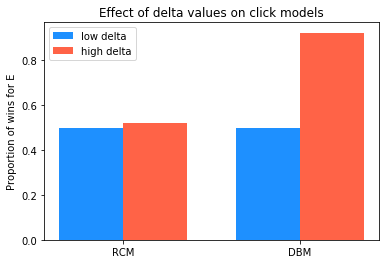

In [37]:
# create new dict with all values for which delta is positive
pairs_dict = {}
for key, value in delta_values.items():
    avg = sum(value, 0.0)/len(value)
    if avg > 0.0:
        pairs_dict[key] = avg

keys = sorted(pairs_dict, key=pairs_dict.get)

index = round(len(pairs_dict)/10)

##### set parameters #######

# get rho out of data
f=open("YandexRelPredChallenge.txt","r")
rho = learn_param_RCM(f)
f.close()

# get sigma out of data                     
f=open("YandexRelPredChallenge.txt","r")
sigma = learn_param_DBM(f)
f.close()


# take first 10 % of the sorted dictionary to represent the low delta values
low_deltas = keys[:index]

# take last 10 % of the sorted dictionary to represent the high delta values
high_deltas = keys[-index:]

# interleave both pair lists
low_delta_results, low_delta_origins = interleaving(low_deltas)
high_delta_results, high_delta_origins = interleaving(high_deltas)

# run the random click model on both delta's
p_RCM_ld, _,_ = RCM_simulation(low_delta_results, low_delta_origins, rho, N)
p_RCM_hd, _,_ = RCM_simulation(high_delta_results, high_delta_origins, rho, N)

# run the dynamic bayesion model on both delta's
p_DBM_ld, _,_ = DBM_simulation(low_delta_results, low_delta_origins, sigma, N)
p_DBM_hd, _,_ = DBM_simulation(high_delta_results, high_delta_origins, sigma, N)

# run statistical tests to find significant differences
scipy.stats.ttest_ind(p_DBM_ld, p_DBM_hd)

####### CREATE PLOT ########

multiple_bars = plt.figure()

x = [0.25,0.8]
names = ['RCM', 'DBM']

bars_lowdelta = [sum(p_RCM_ld)/len(p_RCM_ld), sum(p_DBM_ld)/len(p_DBM_ld)]
bars_highdelta = [sum(p_RCM_hd)/len(p_RCM_hd), sum(p_DBM_hd)/len(p_DBM_hd)]

ax = plt.subplot(111)
ax.bar(x[0]-0.1, bars_lowdelta[0] ,width=0.2,color='dodgerblue',align='center', label = 'low delta')
ax.bar(x[0]+0.1, bars_lowdelta[1] ,width=0.2,color='tomato',align='center', label = 'high delta')
ax.bar(x[1]-0.1, bars_highdelta[0] ,width=0.2,color='dodgerblue',align='center')
ax.bar(x[1]+0.1, bars_highdelta[1] ,width=0.2,color='tomato',align='center')
ax.set_xticks([x[0],x[1]])
ax.set_xticklabels(names)
plt.ylabel('Proportion of wins for E')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title('Effect of delta values on click models')

plt.show()



Figure ?: Effect of delta values on click models. This figure shows the proportion of times where algorithm E provided more links that were clicked than algorithm P in a ranking. The blue bars represent 10% of the delta values where E outperforms P  just slightly (lowest delta values). The red bars represent 10% of the delta values where E outperforms P more clearly (highest delta values). The delta values where calculated by taking the mean of all results of the offline measures per pair. 

From this figure can be concluded that the models as well as the offline metrics seem to work. Pairs are extracted based on their delta measure. Pairs are only considered if E outperforms P (resulting in extraction of all positive delta values). The higher the delta value, the more E outperforms P, meaning the more relevant documents will be provided by E in comparison with P. We thus expected to find differences in only our dynamic bayesian model based on these delta values. For the random click model we did not expect to find any differences, since the probability of clicking on a document does not depend in any way on the relevance of a document. Thus, the manner in which E outperform P (meaning having more relevant documents in an interleaved ranking) will not have any effect on what is clicked.
For the dynamic bayesian model (DBM), we did expect to find differences caused by the difference in delta values. We based this expectation on the fact that in a DBM, relevance has an impact on click probability. Therefore, algorithms that provide more relevant documents in comparison to other algorithms in a ranking will be more likely to win (provide more documents that are clicked on). This effect can be found in the figure above, which shows that within the DBM, E wins by a larger margin if it provides more relevant documents in comparison to P (thus having a larger delta value for the offline measures) . If E outperforms P just slightly (by having a low delta value), E is not more likely to provide more documents that were clicked on, since the algorithms provide roughly the same amount of relevant documents. These results confirm that our offline measures calculate their delta in such a way that it has a high value for pairs where E outperforms P by a large margin and a low valuje for pairs where E outperforms P by a small margin. Moreover, we can conclude that our click models seem to work based on the assumptions that we made beforehand and the results shown in this figure. The RCM is not affected by difference in relevance of provided documents, while the DBM shows that an algorithm that provides relatively more relevant documents is more likely to win (provide more documents that area clicked) than an algorithm that provides relatively less relevant documents.

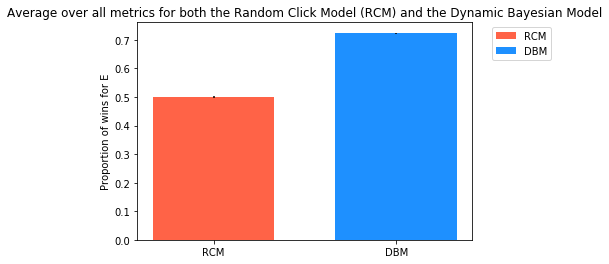

In [34]:
##### PLOT OVER THE AVERAGE OF ALL METRICS #####

# average over all metrics and standard deviation for random click model
avg_ALL_RCM = statistics.mean(p_RCM_list)
stdev_ALL_RCM = statistics.pstdev(p_RCM_list)

# average over all metrics and standard deviation for dynamic bayesian model
avg_ALL_DBM = statistics.mean(p_DBM_list)
stdev_ALL_DBM = statistics.pstdev(p_DBM_list)

# plot bar graph over all metrics, RCM compared to DBM
ax = plt.gca()

x = (1, 1.75)
y = (avg_ALL_RCM, avg_ALL_DBM)
z = (stdev_ALL_RCM, stdev_ALL_DBM)
names = ('RCM', 'DBM')
clr = ('tomato', 'dodgerblue')
for i in range(len(x)):
    plt.bar(x[i], y[i], width=0.5, color = clr[i], yerr = z[i], align="center")

ind = (1,1.75)
plt.xticks(ind, x)
plt.ylabel('Proportion of wins for E')
ax.set_xticklabels(names)

leg = ax.legend(names, loc = 'upper right')
ax.set_title('Average over all metrics for both the Random Click Model (RCM) and the Dynamic Bayesian Model')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change the location of the legend. 
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

The figure above merely implies that our implemented click models seem to work. We used the offline metrics to determine which pairs show that algorithm E provides more relevant documents in comparison to algorithm P. Afterwards, we used these pairs in our click model and simulated the model. 

We expect to find that within the random click model (RCM), no offline metric will significantly differ from 0.5 (based on the plot showing the proportion of wins after taking the average delta of all offline metrics). Thus, the fact that E provides more relevant documents has no effect on its proportion of wins compared to P (50/50) in a RCM. This could be due to the fact that a RCM does not take the relevancy into account. 

When it comes to the dynamic bayesian model (DBM), we expect to find that all metrics will significantly differ from 0.5. We base this expectation on the fact that a DBM takes relevancy into account. As we only simulate the pairs where E has more relevant documents compared to P, E is more likely to provide more documents that will be clicked on. Thus the proportion of wins for E will be significantly higher than 0.5.

## Hypothesis

We will use a binomial test to check for significant differences. Our null hypothesis is that E will not outperform P and thus have a win proportion of about 0.5, whereas our alternative hypothesis is that E does indeed outperform P and thus have a win proportion that is significantly higher than 0.5

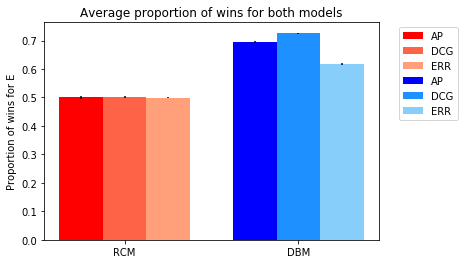

In [33]:
##### PLOTS FOR EACH METRIC #####

# average and standard deviation per metric for random click model
avg_AP_RCM = statistics.mean(p_AP_RCM_list)
stdev_AP_RCM = statistics.pstdev(p_AP_RCM_list)

avg_DCG_RCM = statistics.mean(p_DCG_RCM_list)
stdev_DCG_RCM = statistics.pstdev(p_DCG_RCM_list)

avg_ERR_RCM = statistics.mean(p_ERR_RCM_list)
stdev_ERR_RCM = statistics.pstdev(p_ERR_RCM_list)

# average and standard deviation per metric for random click model
avg_AP_DBM = statistics.mean(p_AP_DBM_list)
stdev_AP_DBM = statistics.pstdev(p_AP_DBM_list)

avg_DCG_DBM = statistics.mean(p_DCG_DBM_list)
stdev_DCG_DBM = statistics.pstdev(p_DCG_DBM_list)

avg_ERR_DBM = statistics.mean(p_ERR_DBM_list)
stdev_ERR_DBM = statistics.pstdev(p_ERR_DBM_list)


# plot bar graph over all metrics, RCM compared to DBM
ax = plt.gca()

#x = range(1, 7)
x = (2,2,2,4,4,4)
y = (avg_AP_RCM, avg_DCG_RCM, avg_ERR_RCM, avg_AP_DBM, avg_DCG_DBM, avg_ERR_DBM)
z = (stdev_AP_RCM, stdev_DCG_RCM, stdev_ERR_RCM, stdev_AP_DBM, stdev_DCG_DBM, stdev_ERR_DBM)
names_leg = ('AP', 'DCG', 'ERR', 'AP', 'DCG', 'ERR')
names = ('RCM', 'DBM')
clr = ('r', 'tomato', 'lightsalmon', 'b', 'dodgerblue', 'lightskyblue')
sides = (0.5, 0, -0.5, 0.5, 0, -0.5)
for i in range(len(x)):
    plt.bar(x[i]-sides[i], y[i], width=0.5, color = clr[i], yerr = z[i], align="center")

ind = (2,4)
plt.xticks(ind, x)
plt.ylabel('Proportion of wins for E')
ax.set_xticklabels(names)

leg = ax.legend(names_leg, loc = 'upper right')
ax.set_title('Average proportion of wins for both models')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change the location of the legend. 
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

Figure ?: Average proportion of wins for both models. The figure above shows the proportion of wins for E, meaning how often algorithm E provided more documents that were clicked on in comparison to algorithm P. The red bars indicate win proportions for the random click model (RCM), whereas the blue bars indicate win proportions for the dynamic bayesian model (DBM). Different shades of the colours represent the offline metrics used.

# Statistics

In [28]:
##### STATISTICAL ANALYSIS #####

def calculate_pval(values, trials):
    success = 0
    if isinstance(trials, int):
        for value in values:
            if value > 0.5:
                success += 1
        pval = scipy.stats.binom_test(success, trials, p=0.5)
    else:
        for i in range(len(values)):
            if values[i]/trials[i] > 0.5:
                success += 1
        pval = scipy.stats.binom_test(success, len(trials), p=0.5)
    
    return pval
    
##### Check which way we want #####

# statistical test over all metrics combined

# first option vs second option
pval_RCM_ALL = calculate_pval(RCM_ALL_wins, RCM_ALL_trials)
pval_DBM_ALL = calculate_pval(DBM_ALL_wins, DBM_ALL_trials)

# statistical test over AP
pval_RCM_AP = calculate_pval(RCM_AP_wins, RCM_AP_trials)
pval_DBM_AP = calculate_pval(DBM_AP_wins, DBM_AP_trials)

# statistical test over DCG
pval_RCM_DCG = calculate_pval(RCM_DCG_wins, RCM_DCG_trials)
pval_DBM_DCG = calculate_pval(DBM_DCG_wins, DBM_DCG_trials)

# statistical test over ERR
pval_RCM_ERR = calculate_pval(RCM_ERR_wins, RCM_ERR_trials)
pval_DBM_ERR = calculate_pval(DBM_ERR_wins, DBM_ERR_trials)

print('Binomial tests to compare whether proportion differs from 0.5:')
print('\n')
print('P-value for RCM all: ', pval_RCM_ALL)
print('P-value for DBM all: ', pval_DBM_ALL)
print('\n')
print('P-value for RCM Average Precision: ', pval_RCM_AP)
print('P-value for RCM DCG: ', pval_RCM_DCG)
print('P-value for RCM ERR: ', pval_RCM_ERR)
print('\n')
print('P-value for DBM AP: ', pval_DBM_AP)
print('P-value for DBM DCG: ', pval_DBM_DCG)
print('P-value for DBM ERR: ', pval_DBM_ERR)



Binomial tests to compare whether proportion differs from 0.5:


P-value for RCM all:  0.118920452559
P-value for DBM all:  1.7763568394e-15


P-value for RCM Average Precision:  0.887724827341
P-value for RCM DCG:  0.322236320358
P-value for RCM ERR:  0.202638751065


P-value for DBM AP:  1.7763568394e-15
P-value for DBM DCG:  1.7763568394e-15
P-value for DBM ERR:  1.7763568394e-15


Significance level: $\alpha = 0.05$

The p-values shown above are the result of running a binomial test on all combinations of online and offline metrics. The binomial test was run to test whether the win proportion deviated from 0.5, meaning whether E would outperform P. In the random click model (RCM) it can be seen that none of the offline metrics leads to a significant difference from 0.5. Therefore, it can be concluded that within a RCM E does not seem to outperform P. This makes sense, as the RCM does not base its click probability on relevancy of documents. The offline metrics were used to determine which pairs had more relevant documents from E than from P. As the relevancy is not taken into account in the RCM, we did not expect to find any significant differences with this test on the model.

However, when it comes to the dynamic bayesian model (DBM) we find that all offline metrics show significant results. This means that within the DBM, all offline metrics show that algorithm E has a significantly higher proportion of wins compared to algorithm P. Beforehand, we expected all these values to be significantly different based on the fact that DBM uses document relevance in order to calculate click probability. Thus, the model is more likely to click on a document that is labeled as being more relevant. We used the offline measures to determine which pairs show that algorithm E provided more relevant documents in comparison with algorithm P. These pairs where then used in the click model, where documents provided by E would be clicked on more just based on the fact that they are more relevant. Due to the fact that we find significant differences on the binomial test on all offline measures, we conclude that documents provided by E are clicked more frequently.

## Differences within models
For further analysis, we decided to check whether the offline metric that was used has an effect on the proportion of wins within both models. For this analysis we decided to use a t-test to find whether or not the proportion of wins differ between the use of different offline metrics within the click models.

In [32]:
##### T-TEST #####

print('Random Click Model analysis:')
stat, pval_AP_DCG_RCM = scipy.stats.ttest_ind(p_AP_RCM_list, p_DCG_RCM_list)
print('T-test p-value between AP and DCG: ', pval_AP_DCG_RCM)

stat, pval_AP_ERR_RCM = scipy.stats.ttest_ind(p_AP_RCM_list, p_ERR_RCM_list)
print('T-test p-value between AP and ERR: ', pval_AP_ERR_RCM)

stat, pval_DCG_ERR_RCM = scipy.stats.ttest_ind(p_DCG_RCM_list, p_ERR_RCM_list)
print('T-test p-value between DCG and ERR: ', pval_DCG_ERR_RCM)
print('\n')

print('Dynamic Bayesian Model analysis:')
stat, pval_AP_DCG_DBM = scipy.stats.ttest_ind(p_AP_DBM_list, p_DCG_DBM_list)
print('T-test p-value between AP and DCG: ', pval_AP_DCG_DBM)

stat, pval_AP_ERR_DBM = scipy.stats.ttest_ind(p_AP_DBM_list, p_ERR_DBM_list)
print('T-test p-value between AP and ERR: ', pval_AP_ERR_DBM)

stat, pval_DCG_ERR_DBM = scipy.stats.ttest_ind(p_DCG_DBM_list, p_ERR_DBM_list)
print('T-test p-value between DCG and ERR: ', pval_DCG_ERR_DBM)


Random Click Model analysis:
T-test p-value between AP and DCG:  0.625320143318
T-test p-value between AP and ERR:  0.460870708855
T-test p-value between DCG and ERR:  0.191650731302


Dynamic Bayesian Model analysis:
T-test p-value between AP and DCG:  2.86822413537e-74
T-test p-value between AP and ERR:  1.11688419708e-114
T-test p-value between DCG and ERR:  3.61675193322e-129


Significance level: $\alpha = 0.05$

As expected, we do not find any significant differences within the random click model (RCM). As mentioned before, this is due to the fact that a RCM does not take relevancy of documents in a ranking into account. This is in line with the results shown in the graph concerning RCM, where differences between proportions of wins are minor.

For the dynamic bayesian model (DBM), we find that every pair seems to significantly differ from one another. The p-values are extremely low, most likely due to the fact that our data has a very small standard deviation. By looking at the graph we find that DCG performs best, Average precision comes in at second and ERR performs worst. 

# Conclusion

Through our test of the evaluation measures, we find that DCG performs best on our data, AP has the second-best performance and ERR performs the worst. A likely cause of the relatively poor performance by ERR is the assumption of independence between queries and documents (which is an assumption that we made within this experiment). ERR is an algorithm designed specifically to tackle the downsides of this assumption and is thus likely to perform better in a real-world application. 

DCG performs better than AP due to the fact that in this implementation of AP the relevance is binary and no disjunction is made between documents that are "relevant" and documents that are "highly relevant".

Below, you can find the percentages of co-occurent pairs between the offline evaluation measures. We find that a high percentage of overlapping pairs seems to correlate to a higher performace of this evaluation measure. We assume that pairs found by only a single measure have a higher chance of being misclassified and thus decrease performance.

In [ ]:
##### Check percentages of overlapping pairs between offline measures #####,

print("AP:",len(AP_pairs))
print("DCG:",len(DCG_pairs))
print("ERR:",len(ERR_pairs))

print("---")

print("AP in DCG:", len(list(set(AP_pairs).intersection(DCG_pairs)))/len(AP_pairs))
print("AP in ERR:", len(list(set(AP_pairs).intersection(ERR_pairs)))/len(AP_pairs))
print("DCG in AP:", len(list(set(DCG_pairs).intersection(AP_pairs)))/len(DCG_pairs))
print("DCG in ERR:", len(list(set(DCG_pairs).intersection(ERR_pairs)))/len(DCG_pairs))
print("ERR in AP:", len(list(set(ERR_pairs).intersection(AP_pairs)))/len(ERR_pairs))
print("ERR in DCG:", len(list(set(ERR_pairs).intersection(DCG_pairs)))/len(ERR_pairs))


Through our test of the evaluation measures, we find that ERR has the worst performance. A likely cause of this relatively poor performance is the assumption of independence between queries and documents. ERR is an algorithm designed specifically to tackle the downsides of this assumption and is thus likely to perform better in a real-world application.